In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from nltk.util import ngrams
from sklearn import model_selection, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from pymorphy2 import MorphAnalyzer
from collections import Counter
import pickle

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [55]:
f = open(r'combine_df.txt', 'rb')
train_df = pickle.load(f)
f.close()
train_df.head()

,id,label,tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...",father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...",thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]",bihday majesti,bihday majesty
3,4,0.0,model love yoyou take with yoyou all the time ...,"[model, love, yoyou, take, with, yoyou, all, t...","[model, love, yoyou, take, yoyou, time, yoyour]",model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0.0,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]",factsguid societi motiv,factsguide society motivation


In [56]:
train_df.drop(columns = ['tweet', 'tweet_token', 'tweet_token_filtered'], axis = 1, inplace=True)
train_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
0,1,0.0,father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday majesti,bihday majesty
3,4,0.0,model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0.0,factsguid societi motiv,factsguide society motivation


In [57]:
train_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
0,1,0.0,father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday majesti,bihday majesty
3,4,0.0,model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0.0,factsguid societi motiv,factsguide society motivation


In [58]:
train_df.isna().sum()

id                      0
label               17197
tweet_stemmed           0
tweet_lemmatized        0
dtype: int64

In [59]:
test_df = train_df[train_df['label'].isnull()] #   train_df[train_df.isnull().any(axis=1)]
test_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
31962,31963,NaN,studiolif aislif requir passion dedic willpow ...,studiolife aislife requires passion dedication...
31963,31964,NaN,white supremacist want everyon see new bird movi,white supremacist want everyone see new bird m...
31964,31965,NaN,safe way heal acn altwaystoh healthi heal,safe way heal acne altwaystoheal healthy healing
31965,31966,NaN,hp curs child book reserv alreadi ye harrypott...,hp cursed child book reservation already yes h...
31966,31967,NaN,rd bihday amaz hilari nephew eli ahmir uncl da...,rd bihday amazing hilarious nephew eli ahmir u...


In [60]:
train_df = train_df.loc[~train_df['label'].isnull()]
train_df['label'] = train_df['label'].astype(int)
train_df.head()

,id,label,tweet_stemmed,tweet_lemmatized
0,1,0,father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0,thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0,bihday majesti,bihday majesty
3,4,0,model love yoyou take yoyou time yoyour,model love yoyou take yoyou time yoyour
4,5,0,factsguid societi motiv,factsguide society motivation


In [61]:
train_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

- Классы сильно не сбалансированны, поэтому на данном этапе буду ориентироваться на кривые Precision-Recall

In [62]:
train_x, valid_x, train_y, valid_y = train_test_split(train_df['tweet_stemmed'], train_df['label'], test_size=0.33, random_state=42)

#### Сначала обучу классификаторы на униграммах with default settings

In [63]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(train_x) # bag of words

In [64]:
list(vec.vocabulary_.items())[:10]

[('bbc', 1736),
 ('news', 14994),
 ('russia', 18604),
 ('lake', 12004),
 ('syamozero', 21100),
 ('children', 3847),
 ('die', 5621),
 ('storm', 20618),
 ('catch', 3520),
 ('boat', 2549)]

In [98]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)   # learning on a bag of words
pred = clf.predict_proba(vec.transform(valid_x))[:,1] # predict
# print(classification_report(pred, valid_y))

In [100]:
precision_CV, recall_CV, thresholds_CV = precision_recall_curve(valid_y, pred)
fscore = (5 * precision_CV * recall_CV) / (4 * precision_CV + recall_CV)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision_CV[ix]:.3f}, Recall={recall_CV[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision_CV[ix]:.3f}, Recall={recall_CV[ix]:.3f}')

Precision=0.475, Recall=0.787
Best Threshold=0.09780786009134537, F-Score=0.696, Precision=0.475, Recall=0.787


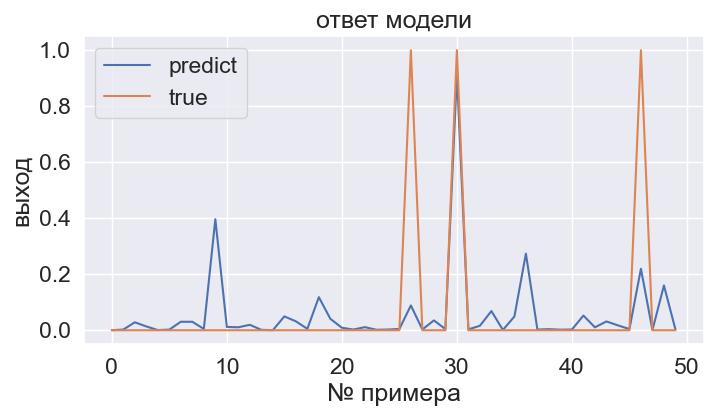

In [95]:
n = 50
plt.figure(figsize=(8, 4))
plt.plot(pred[:n], label='predict')
plt.plot(valid_y.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [93]:
roc_auc_score(valid_y, pred)

0.9422385931271519

Confusion matrix, without normalization
[[9160  646]
 [ 159  583]]


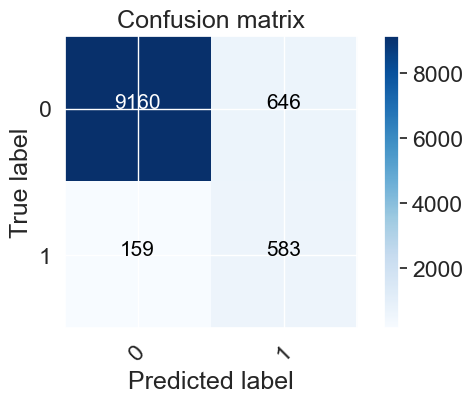

In [96]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(valid_y, pred > thresholds[ix])

plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

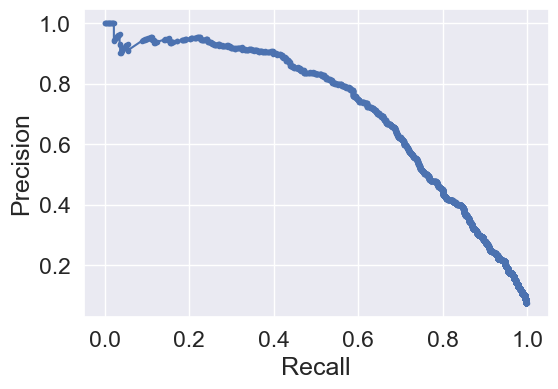

In [103]:
plt.figure(figsize=(6, 4))
plt.plot(recall_CV, precision_CV, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

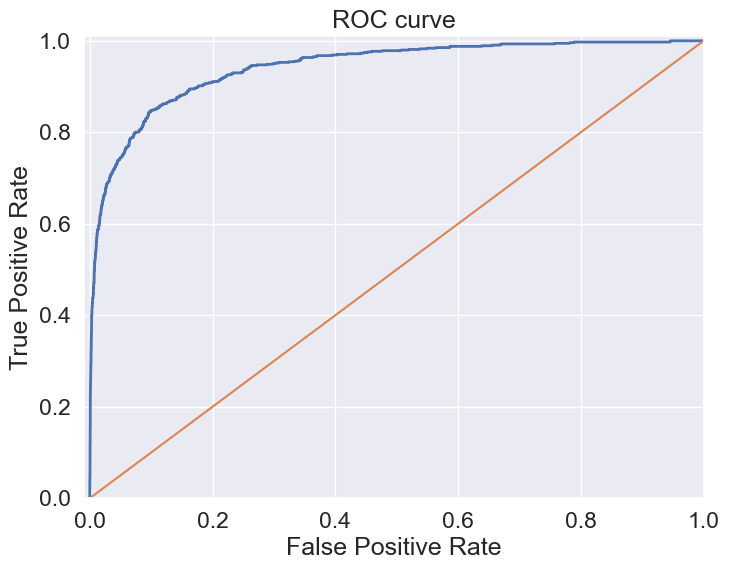

In [49]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [54]:
fpr

array([0.        , 0.        , 0.        , ..., 0.98245972, 0.98266368,
       1.        ])

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9730   76]
 [ 369  373]]


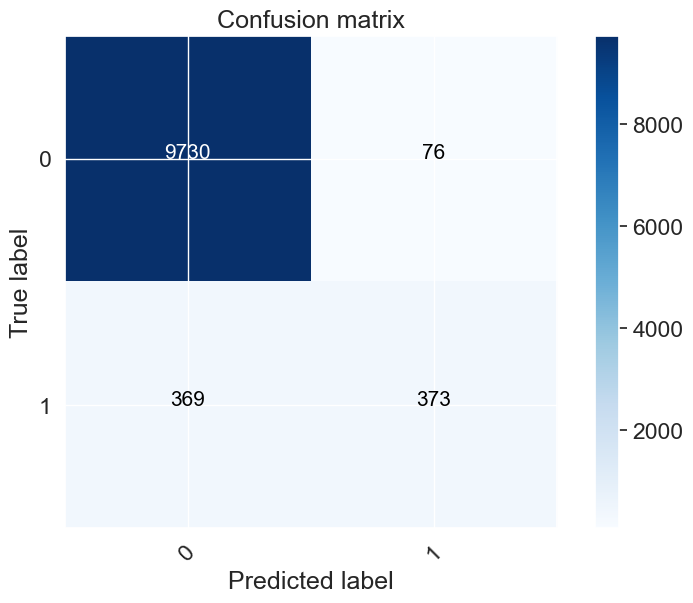

In [53]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(valid_y, pred > thresholds[ix])

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

- Попробуем сделать то же самое для биграмм:

In [14]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict(vec.transform(valid_x))
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10369
           1       0.24      0.99      0.39       179

    accuracy                           0.95     10548
   macro avg       0.62      0.97      0.68     10548
weighted avg       0.99      0.95      0.96     10548



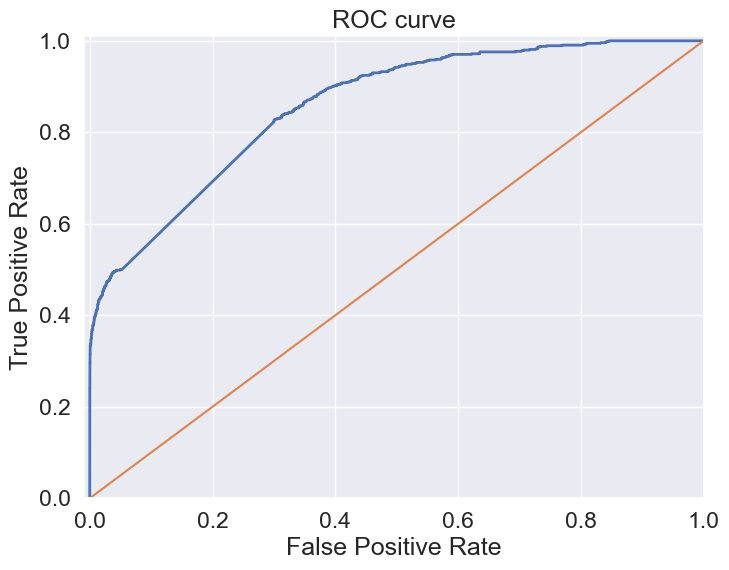

In [15]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

#### Cделаем тоже самое применяя TfidfVectorizer 

In [18]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict(vec.transform(valid_x))
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10308
           1       0.29      0.88      0.43       240

    accuracy                           0.95     10548
   macro avg       0.64      0.92      0.70     10548
weighted avg       0.98      0.95      0.96     10548



In [19]:
fpr_TV, tpr_TV, thresholds_TV = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)

In [20]:
precision, recall, thresholds = precision_recall_curve(valid_y, pred)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.883, Recall=0.286
Best Threshold=1, F-Score=0.432, Precision=0.883, Recall=0.286


In [21]:
roc_auc_score(valid_y, pred)

0.6414294455289764

- Попробуем сделать то же самое для биграмм:

In [22]:
vec = TfidfVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict(vec.transform(valid_x))
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     10474
           1       0.10      1.00      0.18        74

    accuracy                           0.94     10548
   macro avg       0.55      0.97      0.57     10548
weighted avg       0.99      0.94      0.96     10548



---

- Точность (precision) при TfidfVectorizer заметно хуже, чем при CountVectorizer при использовании униграмм. 

- accuracy +- показатель одинаковый и одинаково бесполезен, так как классы не сбалансированы

---

In [23]:
vec = HashingVectorizer(n_features=8000)
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict_proba(vec.transform(valid_x))[:, 1]
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10278
           1       0.31      0.86      0.46       270

    accuracy                           0.95     10548
   macro avg       0.66      0.91      0.72     10548
weighted avg       0.98      0.95      0.96     10548



In [24]:
precision, recall, thresholds = precision_recall_curve(valid_y, pred)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.863, Recall=0.314
Best Threshold=1, F-Score=0.460, Precision=0.863, Recall=0.314


In [25]:
roc_auc_score(valid_y, pred)

0.6551214862125779

In [29]:
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
# наши прогнозы для тестовой выборки
preds = clf.predict_proba(vec.transform(valid_x))[:, 1]
preds[:10]

array([0.00941713, 0.01790648, 0.14004376, 0.03421909, 0.00686725,
       0.01891011, 0.0449918 , 0.08098566, 0.02012474, 0.12509821])

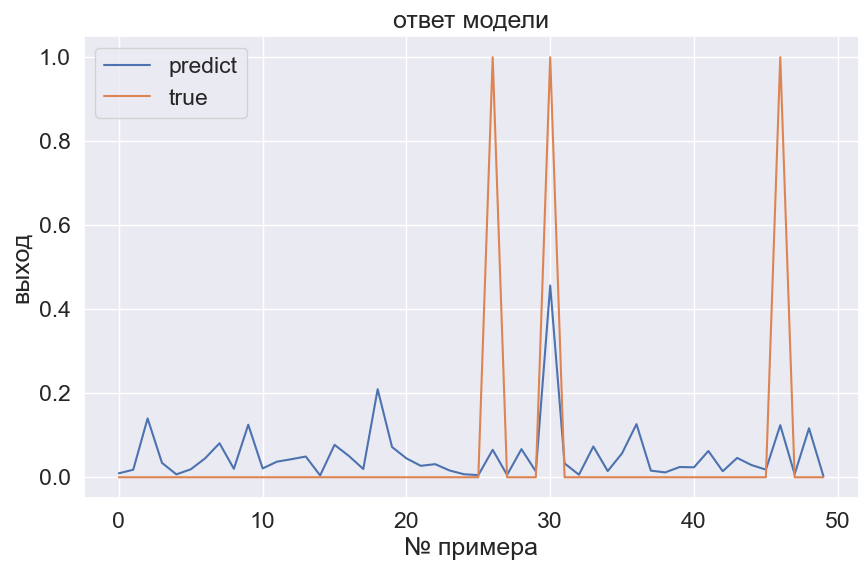

In [28]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(valid_y.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [31]:
precision, recall, thresholds = precision_recall_curve(valid_y, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.656, Recall=0.574
Best Threshold=0.2100044321223301, F-Score=0.613, Precision=0.656, Recall=0.574


In [32]:
roc_auc_score(valid_y, preds)

0.9309766477754695

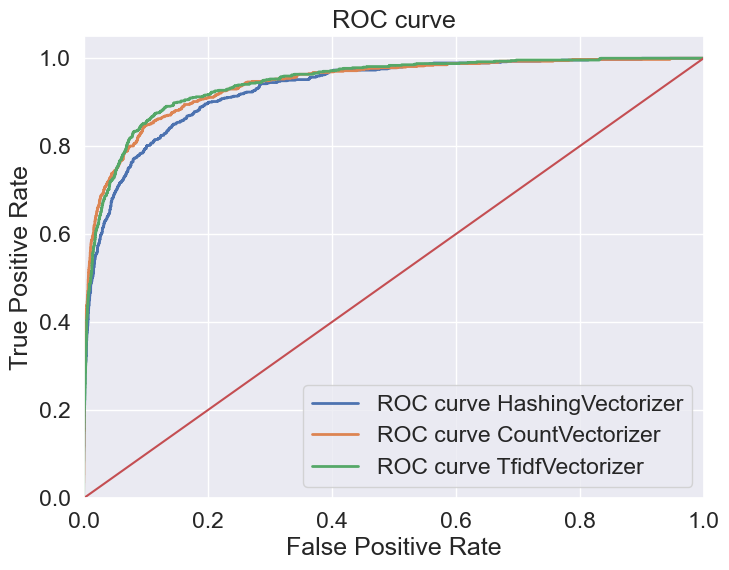

In [256]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr_HV, tpr_HV, thresholds_HV = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
lw = 2
plt.plot(fpr_HV, tpr_HV, lw=lw, label='ROC curve HashingVectorizer')
plt.plot(fpr_CV, tpr_CV, lw=lw, label='ROC curve CountVectorizer')
plt.plot(fpr_TV, tpr_TV, lw=lw, label='ROC curve TfidfVectorizer')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.legend()
plt.show()

---

In [258]:
train_x, valid_x, train_y, valid_y = train_test_split(train_df['tweet_lemmatized'], train_df['label'], test_size=0.33, random_state=42)

In [259]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(train_x) 
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict(vec.transform(valid_x))
fpr_CV, tpr_CV, thresholds_CV = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10110
           1       0.50      0.85      0.63       438

    accuracy                           0.96     10548
   macro avg       0.75      0.91      0.80     10548
weighted avg       0.97      0.96      0.96     10548



In [260]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict(vec.transform(valid_x))
fpr_TV, tpr_TV, thresholds_TV = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10309
           1       0.29      0.89      0.43       239

    accuracy                           0.95     10548
   macro avg       0.64      0.92      0.70     10548
weighted avg       0.98      0.95      0.96     10548



In [261]:
vec = HashingVectorizer(n_features=8000)
bow = vec.fit_transform(train_x)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train_y)
pred = clf.predict(vec.transform(valid_x))
fpr_HV, tpr_HV, thresholds_HV = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
print(classification_report(pred, valid_y))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10291
           1       0.31      0.88      0.45       257

    accuracy                           0.95     10548
   macro avg       0.65      0.92      0.71     10548
weighted avg       0.98      0.95      0.96     10548



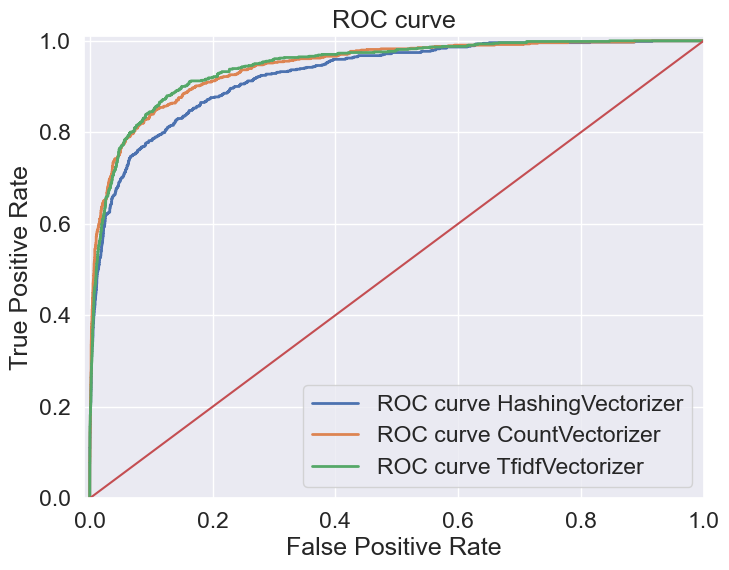

In [266]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr_HV, tpr_HV, thresholds_HV = roc_curve(valid_y, clf.predict_proba(vec.transform(valid_x))[:,1], pos_label=1)
lw = 2
plt.plot(fpr_HV, tpr_HV, lw=lw, label='ROC curve HashingVectorizer')
plt.plot(fpr_CV, tpr_CV, lw=lw, label='ROC curve CountVectorizer')
plt.plot(fpr_TV, tpr_TV, lw=lw, label='ROC curve TfidfVectorizer')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.legend()
plt.show()

---

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [7]:
combine_df = pd.concat([train_df, test_df], ignore_index = True, sort = False)
combine_df.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


In [8]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      49159 non-null  int64  
 1   label   31962 non-null  float64
 2   tweet   49159 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


### Выполним задания с  1 по 10 в следующих функциях. 

In [9]:
def clean_name(name, text):
    return str(re.sub(name, '', text))


def change_of_dict(dictionary, text):
    for el in text.split():
        if el in dictionary:
            if el in fail_dict:
                el_temp = fail_dict[el]
                text = re.sub(el_temp, dictionary[el], text)
            else:
                text = re.sub(el, dictionary[el], text)
    return text


def clean_text(text):
    '''
    очистка текста

    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)

    vect_func = np.vectorize(clean_name)
    
    text = html.unescape(text)              # 1. Заменим html-сущности
    list_name = re.findall("@[\w]*", text)  # 2. Удалим @user из всех твитов

    if list_name:
        text = vect_func(list_name, text)
        text = str(text[0])

    text = text.lower()                     # 3. Изменим регистр твитов на нижний с помощью .lower().

    # 4. Заменим сокращения с апострофами на значение полную версию слова
    text = change_of_dict(apostrophe_dict, text)

    # 5. Заменим сокращения на их полные формы
    text = change_of_dict(short_word_dict, text)

    # 6. Заменим эмотиконы
    text = change_of_dict(emoticon_dict, text)

    # 7. Заменим пунктуацию на пробелы
    text = re.sub(r'[^\w\s]', ' ', text)

    # 8. Заменим спец. символы на пробелы
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    # 9. Заменим числа на пробелы
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 10. Удалим из текста слова длиной в 1 символ
    text = ' '.join([w for w in text.split() if len(w) > 1])

    return text

In [10]:
%%time
import html
from tqdm import tqdm
tqdm.pandas()

CPU times: total: 15.6 ms
Wall time: 12 ms


In [11]:
# Запускаем очистку текста.
combine_df['tweet'] = combine_df['tweet'].progress_apply(lambda x: clean_text(x))

100%|█████████████████████████████████████████████████████████████████████████| 49159/49159 [00:04<00:00, 12011.02it/s]


In [12]:
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk import tokenize as tknz
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 11. Поделим твиты на токены с помощью nltk.tokenize.word_tokenize

In [13]:
combine_df['tweet_token'] = combine_df['tweet'].progress_apply(lambda x: tknz.word_tokenize(x))

100%|██████████████████████████████████████████████████████████████████████████| 49159/49159 [00:10<00:00, 4892.77it/s]


In [15]:
combine_df.tweet_token

0        [when, father, is, dysfunctional, and, is, so,...
1        [thanks, for, lyft, credit, can, not, use, cau...
2                                  [bihday, your, majesty]
3        [model, love, yoyou, take, with, yoyou, all, t...
4                   [factsguide, society, now, motivation]
                               ...                        
49154    [thought, factory, left, right, polarisation, ...
49155    [feeling, like, mermaid, hairflip, neverready,...
49156    [hillary, campaigned, today, in, ohio, omg, us...
49157    [happy, at, work, conference, right, mindset, ...
49158    [my, song, so, glad, free, download, shoegaze,...
Name: tweet_token, Length: 49159, dtype: object

In [16]:
from nltk.corpus import stopwords
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 12. Удалим стоп-слова из токенов, используя nltk.corpus.stopwords.

In [17]:
stop_words = set(stopwords.words("english"))

In [18]:
def del_stop_words(words, stop_words):
    return [word for word in words if word not in stop_words]

In [19]:
combine_df['tweet_token_filtered'] = combine_df['tweet_token'].progress_apply(lambda x: del_stop_words(x, stop_words))

100%|████████████████████████████████████████████████████████████████████████| 49159/49159 [00:00<00:00, 207421.53it/s]


In [20]:
combine_df.tweet_token_filtered

0        [father, dysfunctional, selfish, drags, kids, ...
1        [thanks, lyft, credit, use, cause, offer, whee...
2                                        [bihday, majesty]
3          [model, love, yoyou, take, yoyou, time, yoyour]
4                        [factsguide, society, motivation]
                               ...                        
49154    [thought, factory, left, right, polarisation, ...
49155    [feeling, like, mermaid, hairflip, neverready,...
49156    [hillary, campaigned, today, ohio, omg, used, ...
49157    [happy, work, conference, right, mindset, lead...
49158    [song, glad, free, download, shoegaze, newmusi...
Name: tweet_token_filtered, Length: 49159, dtype: object

### 13. Применим стемминг к токенам с помощью nltk.stem.PorterStemmer.

In [21]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

In [22]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [23]:
def used_stemmer(stemmer, words):
    return [stemmer.stem(word) for word in words]

In [24]:
combine_df['tweet_stemmed'] = combine_df['tweet_token_filtered'].progress_apply(lambda x: used_stemmer(stemmer, x))

100%|██████████████████████████████████████████████████████████████████████████| 49159/49159 [00:14<00:00, 3368.80it/s]


In [25]:
combine_df.tweet_stemmed

0        [father, dysfunct, selfish, drag, kid, dysfunc...
1        [thank, lyft, credit, use, caus, offer, wheelc...
2                                        [bihday, majesti]
3          [model, love, yoyou, take, yoyou, time, yoyour]
4                              [factsguid, societi, motiv]
                               ...                        
49154    [thought, factori, left, right, polaris, trump...
49155    [feel, like, mermaid, hairflip, neverreadi, fo...
49156    [hillari, campaign, today, ohio, omg, use, wor...
49157    [happi, work, confer, right, mindset, lead, cu...
49158    [song, glad, free, download, shoegaz, newmus, ...
Name: tweet_stemmed, Length: 49159, dtype: object

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
def used_lemmatizer(lemmatizer, words):
    return [lemmatizer.lemmatize(word) for word in words]

In [29]:
combine_df['tweet_lemmatized'] = combine_df['tweet_token_filtered'].progress_apply(lambda x: used_lemmatizer(lemmatizer, x))

100%|██████████████████████████████████████████████████████████████████████████| 49159/49159 [00:05<00:00, 8334.64it/s]


In [30]:
combine_df.tweet_lemmatized

0        [father, dysfunctional, selfish, drag, kid, dy...
1        [thanks, lyft, credit, use, cause, offer, whee...
2                                        [bihday, majesty]
3          [model, love, yoyou, take, yoyou, time, yoyour]
4                        [factsguide, society, motivation]
                               ...                        
49154    [thought, factory, left, right, polarisation, ...
49155    [feeling, like, mermaid, hairflip, neverready,...
49156    [hillary, campaigned, today, ohio, omg, used, ...
49157    [happy, work, conference, right, mindset, lead...
49158    [song, glad, free, download, shoegaze, newmusi...
Name: tweet_lemmatized, Length: 49159, dtype: object

In [32]:
f = open(r'combine_df.txt', 'wb')
pickle.dump(combine_df, f)
f.close()